In [10]:
import torch
import torchvision
from torchvision import datasets, transforms 
from sklearn.metrics import classification_report
from torchvision import datasets, models, transforms

%run setup.ipynb

# Basic transfer learning of ResNet50

First, we load in ResNet50. For transfer learning, we want to use this NN for feature extraction at train it to associate those features with the respective classes of our data set. To this end, we freeze all layers except for the final layer, which we alter to have 7 outputs, one for each of our bird species classifications.

In [2]:
# note: this is just copied in from setup.ipynb - just wanted to include it for completeness of the "story"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

pretrained_weights = models.ResNet50_Weights.DEFAULT
def load_and_prep_resnet50(weights = pretrained_weights):
    model = torchvision.models.resnet50(weights=weights)
    
    #Replace last layer to match our 7 classes
    model.fc = torch.nn.Linear(model.fc.in_features, 7)

    # Freeze all layers (i.e., disable training so we dont start from scratch)
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze final layer (named fc) s.t. we only train that to get a better starting point for fine tuning
    for param in model.fc.parameters():
        param.requires_grad = True
    
    # Put the model on the GPU
    model = model.to(device)

    return model


def unfreeze_layers(model):
    for param in model.parameters():
        param.requires_grad = True

def unfreeze_layer4(model: torchvision.models.resnet50):
    model.layer4.requires_grad_ = True    

def get_optimizer(model):
    #Use stochastic gradient descent and optimize parameters
    return torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [3]:
untrained_model = load_and_prep_resnet50()
optimizer = get_optimizer(untrained_model)

Now, we will train the model on our dataset. We'll do a few rounds of training so as to figure out which batch size, epoch number, and optimiser is best. We assess this by considering the loss and accuracy curves throughout training.

In [7]:
# figuring out the number of workers to use on Stinna's pc 
from time import time
import multiprocessing as mp

for num_workers in range(2, mp.cpu_count(), 2):  
    train_loader = torch.utils.data.DataLoader(dataset_train,shuffle=True,num_workers=num_workers,batch_size=16,pin_memory=True)
    start = time()
    for epoch in range(1, 3):
        for i, data in enumerate(train_loader, 0):
            pass
    end = time()
    print("Finish with:{} second, num_workers={}".format(end - start, num_workers))

Finish with:6.491196155548096 second, num_workers=2
Finish with:6.216291189193726 second, num_workers=4
Finish with:6.824495077133179 second, num_workers=6
Finish with:7.793888092041016 second, num_workers=8
Finish with:9.066570281982422 second, num_workers=10
Finish with:10.037089347839355 second, num_workers=12
Finish with:12.013041734695435 second, num_workers=14
Finish with:12.745964527130127 second, num_workers=16
Finish with:13.542078733444214 second, num_workers=18


In [ ]:
# Dataloaders of batch size 16, NB: set num_workers to 4 for stinna's pc and batch size 16 specifically
dataloader_train_16 = torch.utils.data.DataLoader(dataset_train, batch_size=16, num_workers=4, shuffle=True)
dataloader_validation_16 = torch.utils.data.DataLoader(dataset_val, batch_size=16, num_workers=4, shuffle=True)
dataloader_test_16 = torch.utils.data.DataLoader(dataset_test, batch_size=16, num_workers=4, shuffle=False)
dataloader_feeder_16 = torch.utils.data.DataLoader(dataset_feeder, batch_size=16, num_workers=4, shuffle=False)


## Epochs = 60, Batch size = 16, optimiser = SGD

In [12]:
basemodel_60_16, basemodel_60_16_info = train_model(model=untrained_model, optimizer=optimizer, num_epoch=60, train=dataloader_train_16, validation=
                                                    dataloader_validation_16)

Epoch 1/60
----------
Train Loss: 1.8516 Acc: 0.3725
Val Loss: 1.6759 Acc: 0.7212
Epoch time 0m 33s
----------

Epoch 2/60
----------
Train Loss: 1.5510 Acc: 0.7796
Val Loss: 1.4034 Acc: 0.8846
Epoch time 0m 32s
----------

Epoch 3/60
----------
Train Loss: 1.3059 Acc: 0.8683
Val Loss: 1.1988 Acc: 0.9038
Epoch time 0m 33s
----------

Epoch 4/60
----------
Train Loss: 1.1318 Acc: 0.9006
Val Loss: 1.0535 Acc: 0.9135
Epoch time 0m 35s
----------

Epoch 5/60
----------
Train Loss: 1.0006 Acc: 0.9162
Val Loss: 0.9448 Acc: 0.9231
Epoch time 0m 34s
----------

Epoch 6/60
----------
Train Loss: 0.8777 Acc: 0.9377
Val Loss: 0.8176 Acc: 0.9327
Epoch time 0m 34s
----------

Epoch 7/60
----------
Train Loss: 0.8013 Acc: 0.9269
Val Loss: 0.8307 Acc: 0.9519
Epoch time 0m 34s
----------

Epoch 8/60
----------
Train Loss: 0.7309 Acc: 0.9413
Val Loss: 0.7032 Acc: 0.9423
Epoch time 0m 34s
----------

Epoch 9/60
----------
Train Loss: 0.6775 Acc: 0.9401
Val Loss: 0.6872 Acc: 0.9519
Epoch time 0m 34s
----

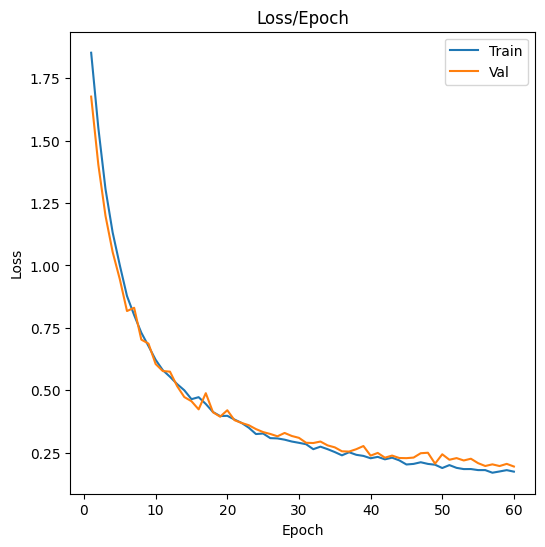

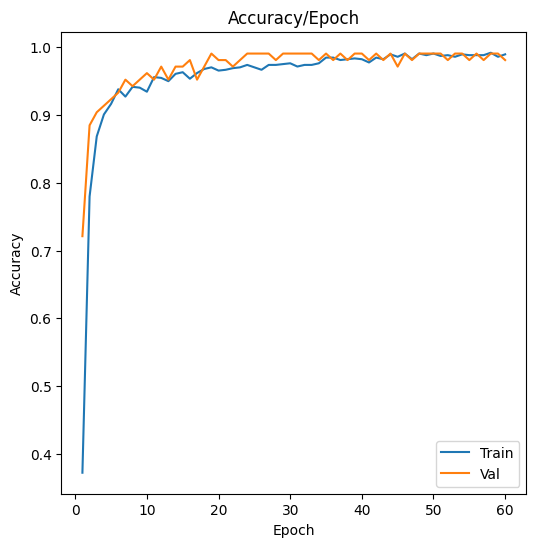

In [18]:
# Plot Loss
plot_loss(basemodel_60_16_info["train_loss"], basemodel_60_16_info["val_loss"], ["Train", "Val"])

# Plot Accuracy
plot_accuracies(basemodel_60_16_info["train_acc"], basemodel_60_16_info["val_acc"], ["Train", "Val"])

The accuracy has converged even though the loss seems to continue to decrease. The val-accuracy reaches the peak at around 24 epochs, and train-acc meets it at around 35 epochs. However, the val-acc starts to get shaky after 33 epochs. So here it seems stopping at 32-33 epochs might be best? 

In [16]:
truel, predl = makeAll(dataloader_test, basemodel_60_16, device)
print("Accuracy", (np.sum(predl==truel)/predl.size * 100))
print(classification_report(truel, predl, target_names=class_labels))

Accuracy 96.19047619047619
              precision    recall  f1-score   support

     blueTit       1.00      1.00      1.00        15
   chaffinch       0.88      1.00      0.94        15
     coalTit       0.88      1.00      0.94        15
   goldfinch       1.00      0.93      0.97        15
    greatTit       1.00      0.87      0.93        15
       robin       1.00      0.93      0.97        15
    starling       1.00      1.00      1.00        15

    accuracy                           0.96       105
   macro avg       0.97      0.96      0.96       105
weighted avg       0.97      0.96      0.96       105



Feeder test

[[  21   34  112  467  740    3  701]
 [   6  526  186 1468  210  150 1006]
 [  11   44  448  899  253    4  187]
 [   1    7   57 1892   30   10    3]
 [   6   31  167  339  869   36  585]
 [  13   23    1  126   53  273  939]
 [  33  159  179  245  278  131 1117]]
Accuracy 96.19047619047619


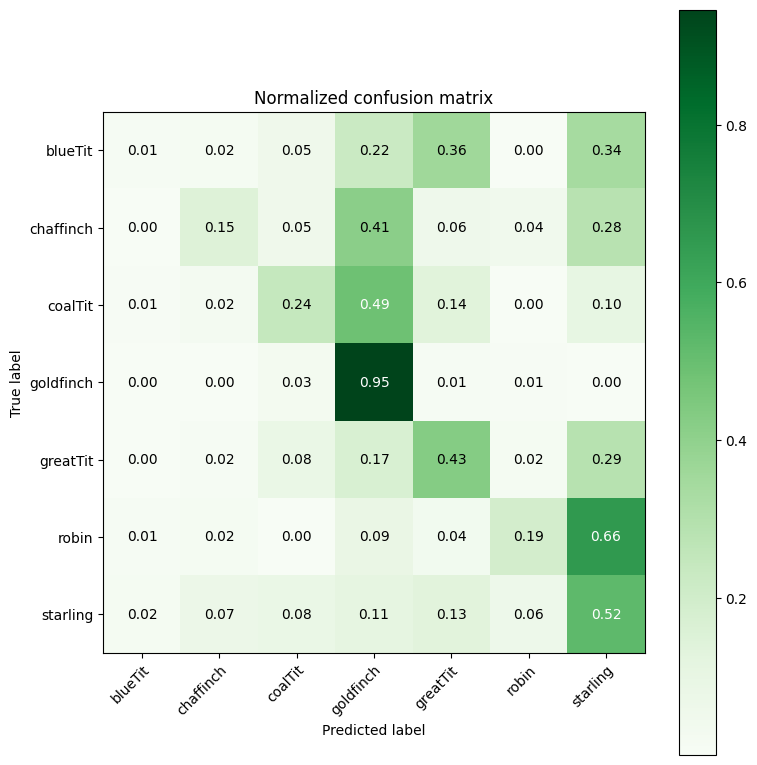

In [ ]:
truel_feeder, predl_feeder = makeAll(dataloader_feeder_16, basemodel_60_16, device)
plot_confusion_matrix(truel_feeder, predl_feeder, class_labels, normalize=True)
print("Accuracy", (np.sum(predl==truel)/predl.size * 100))

In [21]:
print("Accuracy", (np.sum(predl_feeder==truel_feeder)/predl_feeder.size * 100))

Accuracy 34.126931494130915


## Epochs = 60, batch size = 32, optimiser = SGD

Let's see what happens if the batch sizes are larger

In [19]:
# figuring out the number of workers to use on Stinna's pc 
from time import time
import multiprocessing as mp

for num_workers in range(2, mp.cpu_count(), 2):  
    train_loader = torch.utils.data.DataLoader(dataset_train,shuffle=True,num_workers=num_workers,batch_size=32,pin_memory=True)
    start = time()
    for epoch in range(1, 3):
        for i, data in enumerate(train_loader, 0):
            pass
    end = time()
    print("Finish with:{} second, num_workers={}".format(end - start, num_workers))

Finish with:6.8635382652282715 second, num_workers=2
Finish with:7.257557153701782 second, num_workers=4
Finish with:7.434455633163452 second, num_workers=6
Finish with:9.009664058685303 second, num_workers=8
Finish with:9.630154132843018 second, num_workers=10
Finish with:10.472579717636108 second, num_workers=12
Finish with:11.886368036270142 second, num_workers=14
Finish with:12.773701906204224 second, num_workers=16
Finish with:14.231167554855347 second, num_workers=18


In [ ]:
# Dataloaders of batch size 16, NB: set num_workers to 4 for stinna's pc and batch size 16 specifically
dataloader_train_32 = torch.utils.data.DataLoader(dataset_train, batch_size=32, num_workers=4, shuffle=True)
dataloader_validation_32 = torch.utils.data.DataLoader(dataset_val, batch_size=32, num_workers=4, shuffle=True)
dataloader_test_32 = torch.utils.data.DataLoader(dataset_test, batch_size=32, num_workers=4, shuffle=False)
dataloader_feeder_32 = torch.utils.data.DataLoader(dataset_feeder, batch_size=32, num_workers=4, shuffle=False)


In [ ]:
untrained_model = load_and_prep_resnet50()
optimizer = get_optimizer(untrained_model)
basemodel_60_32, basemodel_60_32_info = train_model(model=untrained_model, optimizer=optimizer, num_epoch=60, train=dataloader_train_32, validation=
                                                    dataloader_validation_32)